# 序列模型

使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1, 2, \ldots, 1000$

In [1]:
import sys
sys.path.append('..')

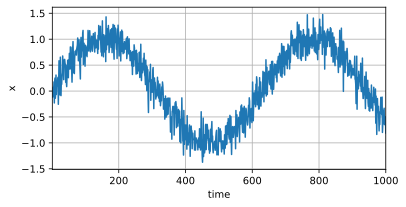

In [2]:
%matplotlib inline
import mindspore
import numpy as np
import mindspore.nn as nn
import mindspore.numpy as mnp
from d2l import mindspore as d2l

T = 1000
time = np.arange(1, T + 1)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [3]:
tau = 4
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个相当简单的架构：只是一个拥有两个全连接层的多层感知机

In [4]:
def get_net():
    net = nn.SequentialCell(nn.Dense(4, 10, weight_init='xavier_uniform'),
                        nn.ReLU(),
                        nn.Dense(10, 1, weight_init='xavier_uniform'))
    return net

loss = nn.MSELoss()

训练模型

In [5]:
def train(net, train_dataset, loss, epochs, lr):
    net_with_loss = nn.WithLossCell(net, loss)
    optim = nn.Adam(net.trainable_params(), lr)
    train = nn.TrainOneStepCell(net_with_loss, optim)
    for epoch in range(epochs):
        for X, y in train_dataset.create_tuple_iterator():
            train(X, y)
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net_with_loss, train_dataset):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.050424
epoch 2, loss: 0.048891
epoch 3, loss: 0.047377
epoch 4, loss: 0.048285
epoch 5, loss: 0.048969


模型预测下一个时间步

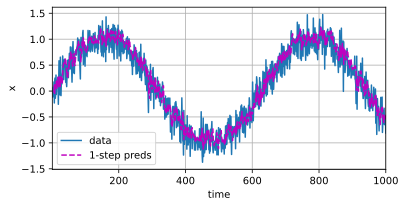

In [6]:
onestep_preds = net(mindspore.Tensor(features, mindspore.float32))
d2l.plot([time, time[tau:]], [x, onestep_preds.asnumpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

进行多步预测

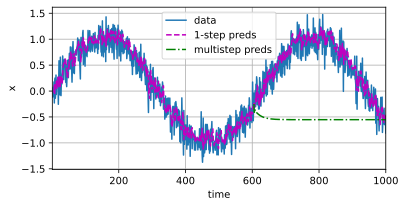

In [7]:
multistep_preds = np.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    result = net(
        mindspore.Tensor(multistep_preds[i - tau:i].reshape((1, -1)), mindspore.float32))
    multistep_preds[i] = result.asnumpy()

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x, onestep_preds.asnumpy(),
          multistep_preds[n_train + tau:]], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下$k$步预测

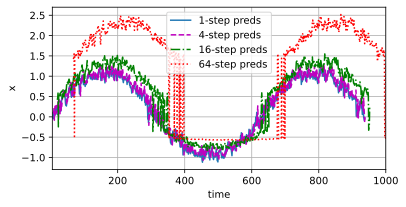

In [8]:
max_steps = 64

features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(mindspore.Tensor(features[:, i - tau:i], mindspore.float32)).reshape(-1).asnumpy()

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)] for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))